Import libraries

In [73]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    trim,
    lower,
    from_json,
    from_unixtime,
    date_format,
    to_utc_timestamp,
    regexp_replace,
    split,
    trim,
    sha2,
    count,
    when,
    mean,
    stddev,
    min,
    max,
    desc,
    asc,
    datediff,
    current_date,
    sum,
)
from pyspark.sql.types import (
    StructType,
    StringType,
    MapType,
    DateType,
    FloatType,
    IntegerType,
    DoubleType,
)
import matplotlib.pyplot as plt

Initialize Spark session

In [2]:
spark = SparkSession.builder.appName("ETL").getOrCreate()

In [3]:
spark

Create Dataset class for running operations on Spark Dataframe 

In [4]:
class Dataset:
    """
    A class to represent and manipulate a PySpark DataFrame.

    Args:
        df (pyspark.sql.DataFrame): The PySpark DataFrame.
    """

    def __init__(self, df: pyspark.sql.DataFrame):
        self.df = df
        self.df_count = self.df.count()

    def show(self, num=20, truncate=False):
        self.df.show(n=num, truncate=truncate)

    def show_df_info(self):
        print("Number of rows:", self.df_count)
        print("Number of columns:", len(self.df.columns))
        print("Column names:", self.df.columns)

    def show_schema(self):
        self.df.printSchema()

    def select_columns(self, column_name: list, number_row=20, truncate=False):
        self.df.select(*column_name).show(n=number_row, truncate=truncate)

    def filter_column_by_value(self, column_name, column_value):
        return self.df.filter(self.df.repr(column_name) == column_value)

    def check_null_count_in_column(self, column_name):
        return self.df.filter(
            (lower(trim(col(column_name))) == "null")
            | (trim(col(column_name)) == "")
            | (col(column_name).isNull())
        ).count()

    def duplicate_rows(self, replace=False):
        if replace:
            self.df = self.df.dropDuplicates()  # df with duplicates removed
        else:
            df_duplicates = self.df.dropDuplicates()

        num_duplicates = self.df_count - df_duplicates.count()
        print(f"Number of duplicate rows: {num_duplicates}")

    def get_unique_values_in_column(self, column_name: str):
        return self.df.select(column_name).distinct().count()

    def get_column_values_count(
        self,
        column_name: str,
        num_show: int = 20,
        show_all: bool = False,
        sort: bool = True,
    ):

        ascending = False if sort else True
        return (
            self.df.groupBy(column_name).count().orderBy("count", ascending=ascending)
        )

    def parse_json_column(self, column_name, schema, rename: str = None):
        """
        Parses a JSON into individual fields based on the provided schema.

        Args:
            column_name (str): The column name containing JSON data.
            schema (StructType): The schema defining the structure of the JSON data.

        """
        if rename:
            column_name = rename
        else:
            column_name = column_name

        self.df = self.df.withColumn(column_name, from_json(col(column_name), schema))

    def extract_json_fields(self, column_mapping: dict):
        """
        Extract fields from a JSON column into separate columns.

        Args:
            column_mapping (dict): A dictionary where keys are JSON paths (e.g., "json_col.field") and values are new column names.
        """
        self.df = self.df.select(
            *self.df.columns,  # include all original columns
            *[
                col(key).alias(new_col_name)  # create new column from key value pair
                for key, new_col_name in column_mapping.items()
            ],
        )

    def cast_column_type(self, column_types: dict):
        """
        Casts columns in a DataFrame to specified types.

        Args:
        column_types (dict): A dictionary where keys are column names and values are the desired Spark data types.

        """
        for col_name, col_type in column_types.items():
            self.df = self.df.withColumn(col_name, col(col_name).cast(col_type))

    def convert_timestamp_to_datetime(
        self,
        column_configs: dict,
        timezone: str = "UTC+8",
    ):
        """
        Transforms timestamp columns to a specific date format and timezone.

        Args:
        column_configs (dict): A dictionary where keys are column names and values are divisors
                            to convert timestamps (e.g., 1000000 for microseconds, 1000 for milliseconds).
        timezone (str): The target timezone for the conversion (default is 'UTC+8').

        """
        for column_name, convert_value in column_configs.items():
            self.df = self.df.withColumn(
                column_name,
                to_utc_timestamp(
                    from_unixtime(col(column_name).cast("double") / convert_value),
                    timezone,
                ),
            )

    def convert_date_format(
        self,
        column_names: list,
        timezone: str = "UTC+8",
        format="yyyy-MM-dd HH:mm:ss.SSSSSS Z",
    ):
        for column in column_names:
            self.df = self.df.withColumn(
                column, date_format(to_utc_timestamp(col(column), timezone), format)
            )

    def drop_column(self, columns: list):
        self.df = self.df.drop(*columns)

    def replace_regex_in_column(self, column_name, regex, replace):
        self.df = self.df.withColumn(
            column_name, regexp_replace(col(column_name), regex, replace)
        )

    def hash_column(self, columns: list):
        for column in columns:
            self.df = self.df.withColumn(column, sha2(column, 256))

    def show_columns_null_count(self):
        self.df.select(
            [
                count(
                    when(
                        col(c).isNull()
                        | (lower(trim(col(c))) == "null")  # check for string "null"
                        | (trim(col(c)) == ""),
                        c,
                    )  # check for blank
                ).alias(c)
                for c in self.df.columns
            ]
        ).show()

    def describe_column(self, columns: list):
        self.df.select(*columns).describe().show()

    def to_pandas(self):
        return self.df.toPandas()

Initialize file

In [5]:
data_file = "cc_sample_transaction.json"

In [6]:
df = spark.read.json(data_file)

## Data Transformation

Create transaction_data object with the dataframe 

In [7]:
transaction_data = Dataset(df)

In [8]:
transaction_data.show_schema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



Transform personal_detail column

Parse json in personal_detail column including nested json to create new column from json keys

In [9]:
personal_detail_schema = (
    StructType()
    .add("person_name", StringType())
    .add("gender", StringType())
    .add("address", StringType())
    .add("lat", StringType())
    .add("long", StringType())
    .add("city_pop", StringType())
    .add("job", StringType())
    .add("dob", DateType())
)

In [10]:
transaction_data.parse_json_column(
    column_name="personal_detail", schema=personal_detail_schema
)

Convert keys in personal_detail and personal_detail.address into individual columns

In [11]:
personal_detail_keys = {
    "personal_detail.person_name": "name",
    "personal_detail.gender": "gender",
    "personal_detail.address": "address",
    "personal_detail.lat": "lat",
    "personal_detail.long": "long",
    "personal_detail.city_pop": "city_pop",
    "personal_detail.job": "job",
    "personal_detail.dob": "dob",
}

In [12]:
transaction_data.extract_json_fields(column_mapping=personal_detail_keys)

In [13]:
address_schema = MapType(StringType(), StringType())
transaction_data.parse_json_column(column_name="address", schema=address_schema)

In [14]:
address_keys = {
    "address.street": "street",
    "address.city": "city",
    "address.state": "state",
    "address.zip": "zip",
}

In [15]:
transaction_data.extract_json_fields(column_mapping=address_keys)

In [16]:
transaction_data.show()

+----------+------+-------------+-----------+-------------------+--------+----------------+----------------------+------------------+------------------+-------------+----------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+--------------------------------+-------------------------+------+---------------------------------------------------------------------------------------------------+-------+------------------+--------+---------------------------------------------+----------+------------------------------+------------------------+-----+-----+
|Unnamed: 0|amt   |category     |cc_bic     |cc_num             |is_fraud|merch_eff_time  |merch_last_update_time|merch_lat         |merch_long        |merch_zipcode|merchant                                |personal_detail                                  

Remove old columns

In [17]:
columns_to_remove = ["personal_detail", "address"]
transaction_data.drop_column(columns_to_remove)

Display new data structure

In [18]:
transaction_data.show_schema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)



Cast appropriate type to other columns except datetime columns

In [19]:
column_types = {
    "Unnamed: 0": IntegerType(),
    "amt": FloatType(),
    "category": StringType(),
    "cc_bic": StringType(),
    "cc_num": StringType(),
    "is_fraud": IntegerType(),
    "merch_lat": DoubleType(),
    "merch_long": DoubleType(),
    "lat": DoubleType(),
    "long": DoubleType(),
    "merch_zipcode": StringType(),
    "merchant": StringType(),
    "trans_num": StringType(),
}

In [20]:
transaction_data.cast_column_type(column_types=column_types)

In [21]:
transaction_data.show_schema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- amt: float (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)


Transform columns with timestamp to datetime format

In [22]:
transaction_data.select_columns(
    ["merch_eff_time", "merch_last_update_time"], number_row=100
)

+----------------+----------------------+
|merch_eff_time  |merch_last_update_time|
+----------------+----------------------+
|1325376018798532|1325376018666         |
|1325376044867960|132537604479          |
|1325376051506840|1325376051286         |
|1325376076794698|1325376076365         |
|1325376186746376|132537618681          |
|1325376248271406|1325376248483         |
|1325376282274130|1325376282247         |
|1325376308837349|1325376308152         |
|1325376318245892|1325376318278         |
|1325376361965234|1325376361857         |
|1325376383967287|1325376383455         |
|1325376413912233|1325376413859         |
|1325376416569264|1325376416443         |
|1325376447442465|1325376447771         |
|132537654399153 |1325376543282         |
|1325376560448213|1325376560435         |
|132537664977977 |1325376649369         |
|1325376658780653|1325376658125         |
|1325376674645606|1325376674800         |
|132537675433224 |1325376754863         |
|1325376788679431|1325376788881   

It seems that merch_eff_time is a timestamp with mostly 16 digits. Unix timestamp is 10 digit format in seconds, so we assume that for merch_eff_time the value is in microseconds therefore we have to divide it by 1M to get the value in seconds.

For merch_last_update_time column, it mostly contains 13/12 digits so we assume that it is in miliseconds and we can divide by 1000 to get the timestamp in seconds.

However, I am not too sure if this correct because the datetime differs greatly from the column trans_date_trans_time.

In [23]:
timestamp_columns = {"merch_eff_time": 1000000, "merch_last_update_time": 1000}

In [24]:
transaction_data.convert_timestamp_to_datetime(timestamp_columns)

In [25]:
transaction_data.select_columns(["merch_eff_time", "merch_last_update_time"])

+-------------------+----------------------+
|merch_eff_time     |merch_last_update_time|
+-------------------+----------------------+
|2012-01-01 00:00:18|2012-01-01 00:00:18   |
|2012-01-01 00:00:44|1974-03-15 00:00:04   |
|2012-01-01 00:00:51|2012-01-01 00:00:51   |
|2012-01-01 00:01:16|2012-01-01 00:01:16   |
|2012-01-01 00:03:06|1974-03-15 00:00:18   |
|2012-01-01 00:04:08|2012-01-01 00:04:08   |
|2012-01-01 00:04:42|2012-01-01 00:04:42   |
|2012-01-01 00:05:08|2012-01-01 00:05:08   |
|2012-01-01 00:05:18|2012-01-01 00:05:18   |
|2012-01-01 00:06:01|2012-01-01 00:06:01   |
|2012-01-01 00:06:23|2012-01-01 00:06:23   |
|2012-01-01 00:06:53|2012-01-01 00:06:53   |
|2012-01-01 00:06:56|2012-01-01 00:06:56   |
|2012-01-01 00:07:27|2012-01-01 00:07:27   |
|1974-03-15 00:00:54|2012-01-01 00:09:03   |
|2012-01-01 00:09:20|2012-01-01 00:09:20   |
|1974-03-15 00:01:04|2012-01-01 00:10:49   |
|2012-01-01 00:10:58|2012-01-01 00:10:58   |
|2012-01-01 00:11:14|2012-01-01 00:11:14   |
|1974-03-1

In [26]:
transaction_data.convert_date_format(
    ["merch_eff_time", "merch_last_update_time", "trans_date_trans_time"]
)

After converted to a human-readable timestamp format in UTC +8 timezone (e.g., YYYY-MM-DD HH:MM.SSSSSS Z)

In [27]:
transaction_data.select_columns(
    ["merch_eff_time", "merch_last_update_time", "trans_date_trans_time"]
)

+--------------------------------+--------------------------------+--------------------------------+
|merch_eff_time                  |merch_last_update_time          |trans_date_trans_time           |
+--------------------------------+--------------------------------+--------------------------------+
|2011-12-31 16:00:18.000000 +0800|2011-12-31 16:00:18.000000 +0800|2018-12-31 16:00:18.000000 +0800|
|2011-12-31 16:00:44.000000 +0800|1974-03-14 16:00:04.000000 +0800|2018-12-31 16:00:44.000000 +0800|
|2011-12-31 16:00:51.000000 +0800|2011-12-31 16:00:51.000000 +0800|2018-12-31 16:00:51.000000 +0800|
|2011-12-31 16:01:16.000000 +0800|2011-12-31 16:01:16.000000 +0800|2018-12-31 16:01:16.000000 +0800|
|2011-12-31 16:03:06.000000 +0800|1974-03-14 16:00:18.000000 +0800|2018-12-31 16:03:06.000000 +0800|
|2011-12-31 16:04:08.000000 +0800|2011-12-31 16:04:08.000000 +0800|2018-12-31 16:04:08.000000 +0800|
|2011-12-31 16:04:42.000000 +0800|2011-12-31 16:04:42.000000 +0800|2018-12-31 16:04:42.0000

Clean name column and extract first, last name

Name Derivation: Extract first and last name columns from person_name:
- The expected format is based on "first, last" but you may
encounter dirty data. Please process the name based on following
example:
    - person_name: "Edward, Sanchez" should result in First: "Edward" and Last: "Sanchez".

In [28]:
transaction_data.select_columns(["name"])

+-------------------------+
|name                     |
+-------------------------+
|Jennifer,Banks,eeeee     |
|Stephanie,Gill,eeeee     |
|Edward@Sanchez           |
|Jeremy/White, !          |
|Tyler@Garcia             |
|Jennifer,Conner,eeeee    |
|Kelsey, , Richards NOOOO |
|Steven, Williams         |
|Heather, , Chase NOOOO   |
|Melissa@Aguilar          |
|Eddie|Mendez!!!          |
|Theresa@Blackwell        |
|Charles|Robles!!!        |
|Jack@Hill                |
|Christopher@Castaneda    |
|Ronald@Carson            |
|Lisa, Mendez             |
|Nathan,Thomas,eeeee      |
|Justin, Gay              |
|Kenneth, , Robinson NOOOO|
+-------------------------+
only showing top 20 rows



Replace punctuations in string with empty space

In [29]:
transaction_data.replace_regex_in_column("name", r"[,@|/!]", " ")

This text cleaning function might be too specific for this dataset, therefore I will not create any function for this in the class to keep it generic and reusable across other datasets

Split the text into array of words

In [30]:
transaction_data.df = transaction_data.df.withColumn(
    "split_name", split(trim(col("name")), r"\s+")
)

In [31]:
transaction_data.select_columns(["name", "split_name"])

+-------------------------+--------------------------+
|name                     |split_name                |
+-------------------------+--------------------------+
|Jennifer Banks eeeee     |[Jennifer, Banks, eeeee]  |
|Stephanie Gill eeeee     |[Stephanie, Gill, eeeee]  |
|Edward Sanchez           |[Edward, Sanchez]         |
|Jeremy White             |[Jeremy, White]           |
|Tyler Garcia             |[Tyler, Garcia]           |
|Jennifer Conner eeeee    |[Jennifer, Conner, eeeee] |
|Kelsey    Richards NOOOO |[Kelsey, Richards, NOOOO] |
|Steven  Williams         |[Steven, Williams]        |
|Heather    Chase NOOOO   |[Heather, Chase, NOOOO]   |
|Melissa Aguilar          |[Melissa, Aguilar]        |
|Eddie Mendez             |[Eddie, Mendez]           |
|Theresa Blackwell        |[Theresa, Blackwell]      |
|Charles Robles           |[Charles, Robles]         |
|Jack Hill                |[Jack, Hill]              |
|Christopher Castaneda    |[Christopher, Castaneda]  |
|Ronald Ca

Create individual column based on the first and second item in the array
- Assumption is made that between the first and last name will always be the first and second item in the array, this will not work correctly if there are other words in between them

In [32]:
transaction_data.df = transaction_data.df.withColumn(
    "first", col("split_name").getItem(0)
).withColumn("last", col("split_name").getItem(1))

In [33]:
transaction_data.select_columns(["name", "first", "last"])

+-------------------------+-----------+---------+
|name                     |first      |last     |
+-------------------------+-----------+---------+
|Jennifer Banks eeeee     |Jennifer   |Banks    |
|Stephanie Gill eeeee     |Stephanie  |Gill     |
|Edward Sanchez           |Edward     |Sanchez  |
|Jeremy White             |Jeremy     |White    |
|Tyler Garcia             |Tyler      |Garcia   |
|Jennifer Conner eeeee    |Jennifer   |Conner   |
|Kelsey    Richards NOOOO |Kelsey     |Richards |
|Steven  Williams         |Steven     |Williams |
|Heather    Chase NOOOO   |Heather    |Chase    |
|Melissa Aguilar          |Melissa    |Aguilar  |
|Eddie Mendez             |Eddie      |Mendez   |
|Theresa Blackwell        |Theresa    |Blackwell|
|Charles Robles           |Charles    |Robles   |
|Jack Hill                |Jack       |Hill     |
|Christopher Castaneda    |Christopher|Castaneda|
|Ronald Carson            |Ronald     |Carson   |
|Lisa  Mendez             |Lisa       |Mendez   |


Remove old name columns

In [34]:
transaction_data.drop_column(["name", "split_name"])

### PII (Personally Identifiable Information)
- Refers to any data that can potentially identify an individual for example:
   - Full name (first name + last name)
   - Credit card number, ID number, email address, etc.
- This dataset contains a few PII data such as `cc_num` (credit card number) and `name` (full name)
- An address by itself might not be considered PII as many individuals can have the same address, but it can become PII when combined with other identifiers (i.e name, DOB, gender) because it can uniquely identify an individual when combined with other data


### Handling PII data
1. **Hashing**:
   - Hashing is a one-way function that converts data (like a credit card number or name) into a fixed-length string of characters. Hashing is deterministic, which means it will always return the same value with the same input
   - By hashing PII data such as credit card numbers or names, we can prevent the original data from being exposed while still being able to perform operations like comparisons or matching. For example, if you hash the name and compare it with another hashed name, you can identify matches without exposing the original data.
   - However, hashing is irreversible, therefore we cannot get back the original value from the hashed value 
   - Its more suitable for situations where you only need to verify the identity of data (i.e checking if two values match) and not for recovering the original data.

2. **Encryption for Enhanced Security**:
   - Hashing is one-way and cannot be undone, but encryption is reversible, which means we can encrypt the value and perform decryption on the encrypted value to get back the original data
   - This is useful when you need to save/retrieve the original data

For this assignment, I will use Pyspark built in SHA-256 hashing to manage PII data since there is no requirement to retain or retrieve the original information.

In [35]:
pii_columns = ["cc_num", "first", "last"]

In [36]:
transaction_data.hash_column(pii_columns)

In [37]:
transaction_data.select_columns(pii_columns)

+----------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------+
|cc_num                                                          |first                                                           |last                                                            |
+----------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------+
|80923ef01336409c8bfd3f8f5689196742e2c9871c0275e6cf5733d0facfd843|bda0a01c76aae97ef15d6b792f3dc3cbb6609d611e9c563a54a1393fe685e31b|0959e9bdd3051a4157de0f2cc72703c78d4bf8b14eb57cc0f684b5b466b2cac3|
|f80a8e60a9f15ecf1b85ba3370ff9c2dc0242190d8bbb71fd4f95d0675002ce7|6307ab01368bdf95d382b574131d1223a6ebc16f44394d0dc0fa9361e432434a|7cb75541ff2bcd4007c78e1d19fd17b68178a40c6f4f31cb1a643f72815dfc79|
|756a303c0348d0

Final data structure 

In [38]:
transaction_data.show_schema()

root
 |-- Unnamed: 0: integer (nullable = true)
 |-- amt: float (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: double (nullable = true)
 |-- merch_long: double (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- city_pop: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip: string (nullable = true)
 |-- first: string (nullable = true)

# Data Analytics and Visualization

## Dataset statistics

Show basic information on the dataset such as number of rows, number of columns and the column names

In [39]:
transaction_data.show_df_info()

Number of rows: 1296675
Number of columns: 26
Column names: ['Unnamed: 0', 'amt', 'category', 'cc_bic', 'cc_num', 'is_fraud', 'merch_eff_time', 'merch_last_update_time', 'merch_lat', 'merch_long', 'merch_zipcode', 'merchant', 'trans_date_trans_time', 'trans_num', 'gender', 'lat', 'long', 'city_pop', 'job', 'dob', 'street', 'city', 'state', 'zip', 'first', 'last']


Check if data contains null values

In [40]:
transaction_data.show_columns_null_count()

+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|Unnamed: 0|amt|category|cc_bic|cc_num|is_fraud|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant|trans_date_trans_time|trans_num|gender|lat|long|city_pop|job|dob|street|city|state|zip|first|last|
+----------+---+--------+------+------+--------+--------------+----------------------+---------+----------+-------------+--------+---------------------+---------+------+---+----+--------+---+---+------+----+-----+---+-----+----+
|         0|  0|       0|288595|     0|       0|             0|                     0|        0|         0|       195973|       0|                    0|        0|     0|  0|   0|       0|  0|  0|     0|   0|    0|  0|    0|   0|
+----------+---+--------+------+------+--------+--------------+---------------------

Assess the impact of null values on the following columns:
- cc_bic
- merch_zipcode

### Credit Card BIC Code
==============================================================================================================================================
Purpose: It identifies the financial institution involved in the transaction, helping to ensure that funds are transferred to the correct bank.

Format: The BIC code is 8 to 11 characters long and is structured as follows:
  - 4 characters for the bank code (identifies the financial institution).
  - 2 characters for the country code (e.g., "US" for the United States, "GB" for the United Kingdom).
  - 2 characters for the location code (city or region).
  - 3 optional characters for the branch code (optional; used if you need to specify a particular branch of the bank).
  
A BIC code is primarily used in cross-border payments like wire transfers and international settlements but is not directly linked to credit card numbers. In the context of credit cards, BIC codes might appear on transaction records or payment processing systems to identify the bank handling the transaction.

Credit card BIC codes (Bank Identifier Codes) are generally not mandatory for credit card transactions. The BIC code is primarily used in international bank transfers or wire transfers to identify financial institutions and is not directly tied to the transaction details for typical credit card payments.

==============================================================================================================================================

Based on the following explanation from the internet, we will assume that columns without values are for non international bank/wire transfers and those that contains valid values are for international transactions. We can replace the null or blank values with a generic "NA" value to indicate that for the transaction, the cc_bic is Not Applicable.



In [41]:
transaction_data.df = transaction_data.df.withColumn(
    "cc_bic",
    when(
        (col("cc_bic").isNull())
        | (trim(col("cc_bic")) == "")
        | (trim(lower(col("cc_bic"))) == "null"),
        "NA",
    ).otherwise(col("cc_bic")),
)

### Merchant Zipcode

**Purpose**: To identify the specific regions, locations, or addresses

Aside from merch_zipcode, other locations data that are in the dataset includes latitude (merch_lat) and longitude (merch_long) that can be used to determine the geographic location of the merchant. 

From PCI guidelines, it is not always required in the transaction detail but recommended to enhance fraud detection.

Based on those observations, we will assume that this column is optional and that null values would not have much impact if it's absent especially when other location data is also present.

Therefore, I will remain the null values as is in the merch_zipcode column


Check for duplicate rows

In [42]:
transaction_data.duplicate_rows()

Number of duplicate rows: 0


Check for distinct values in each columns

In [43]:
all_unique_columns = []
columns_with_repeat = []

In [44]:
for c in transaction_data.df.columns:
    unique_values = transaction_data.get_unique_values_in_column(c)
    (
        all_unique_columns.append(c)
        if unique_values == transaction_data.df_count
        else columns_with_repeat.append((c, unique_values))
    )

In [45]:
columns_with_repeat

[('amt', 52928),
 ('category', 14),
 ('cc_bic', 7),
 ('cc_num', 983),
 ('is_fraud', 2),
 ('merch_eff_time', 1276958),
 ('merch_last_update_time', 1276942),
 ('merch_lat', 1247805),
 ('merch_long', 1275745),
 ('merch_zipcode', 28337),
 ('merchant', 693),
 ('trans_date_trans_time', 1274791),
 ('gender', 2),
 ('lat', 968),
 ('long', 969),
 ('city_pop', 879),
 ('job', 494),
 ('dob', 968),
 ('street', 983),
 ('city', 894),
 ('state', 51),
 ('zip', 970),
 ('first', 352),
 ('last', 481)]

### Helper functions for plotting charts

In [46]:
def plot_bar_chart(df_x, df_y, title, x_label, y_label, rotate=None):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_x, df_y)

    for bar in bars:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{bar.get_height():.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if rotate:
        plt.xticks(rotation=rotate)
    plt.tight_layout()
    plt.show()

In [47]:
def plot_pie_chart(value, label, title):
    plt.figure(figsize=(8, 4))
    plt.pie(value, labels=label, autopct="%1.1f%%", startangle=140)
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Customer Analysis

Statistics for transaction amount

In [48]:
transaction_data.describe_column(["amt"])

+-------+------------------+
|summary|               amt|
+-------+------------------+
|  count|           1296675|
|   mean| 70.35103545681683|
| stddev|160.31603832678482|
|    min|               1.0|
|    max|           28948.9|
+-------+------------------+



Transaction amount grouped by cardholder

In [49]:
grouped_cc_num = transaction_data.df.groupBy("cc_num").agg(
    count("amt").alias("count"),
    mean("amt").alias("mean"),
    min("amt").alias("min"),
    max("amt").alias("max"),
    stddev("amt").alias("stddev"),
)

Show the top 10 spender by the number of transaction made, the average transaction amount, the highest transaction amount, and the highest minimum amount spent across all transactions by the cardholder

In [50]:
order_by = ["count", "mean", "max", "min"]

for variable in order_by:
    print("Order by:", variable)
    if variable == "min":
        grouped_cc_num.orderBy(asc(variable)).show(n=10, truncate=False)
    else:
        grouped_cc_num.orderBy(desc(variable)).show(n=10, truncate=False)

Order by: count
+----------------------------------------------------------------+-----+------------------+----+-------+------------------+
|cc_num                                                          |count|mean              |min |max    |stddev            |
+----------------------------------------------------------------+-----+------------------+----+-------+------------------+
|1d23a78a489b4e6eeb50199670527c67b6616ad71a3b316247d74d2507949977|3123 |61.45309954891211 |1.01|3413.05|143.16260996513978|
|2776266470b9b04633f76717e941c373187376e99ad5b801aa15f2100ea037a3|3123 |55.35335576274706 |1.0 |4304.22|121.66111713560507|
|e2097d89a4b23b168450c9f5d25b08f3bd8ef516788381ee991e8c50060d3e70|3119 |89.77494376670401 |1.02|1469.33|118.4502096704451 |
|adcf6522b3114d26427d7aa4f595be549bc8d9531aa1d4daf470d577b45f4d43|3117 |57.545194339629816|1.0 |8255.19|211.40220579753523|
|d593f8171110027432b7a73f0858730160ac8880b1a37680f32b8dfa6ebd46f2|3113 |48.478949442347876|1.01|4185.61|131.56691581

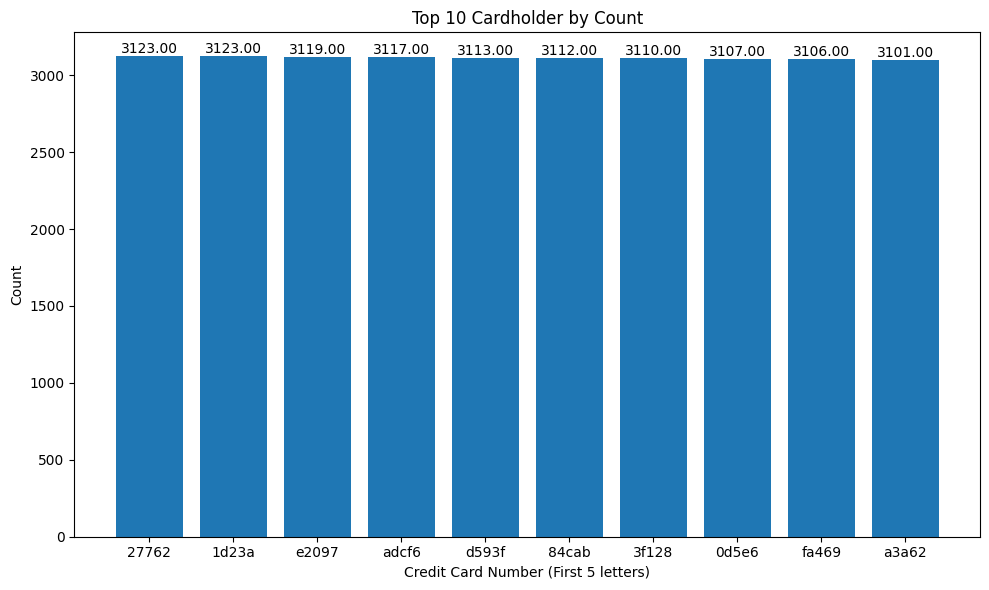

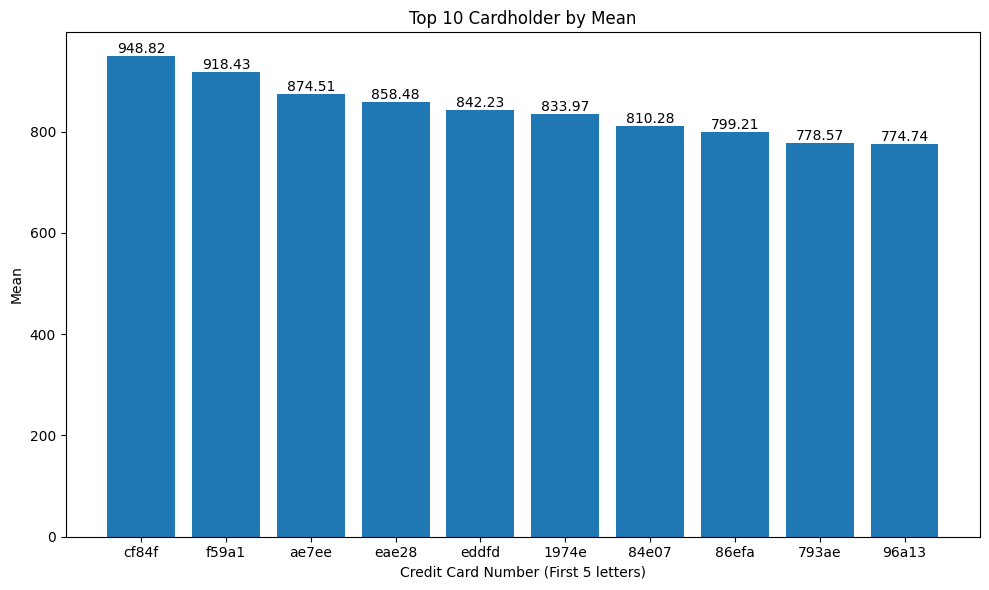

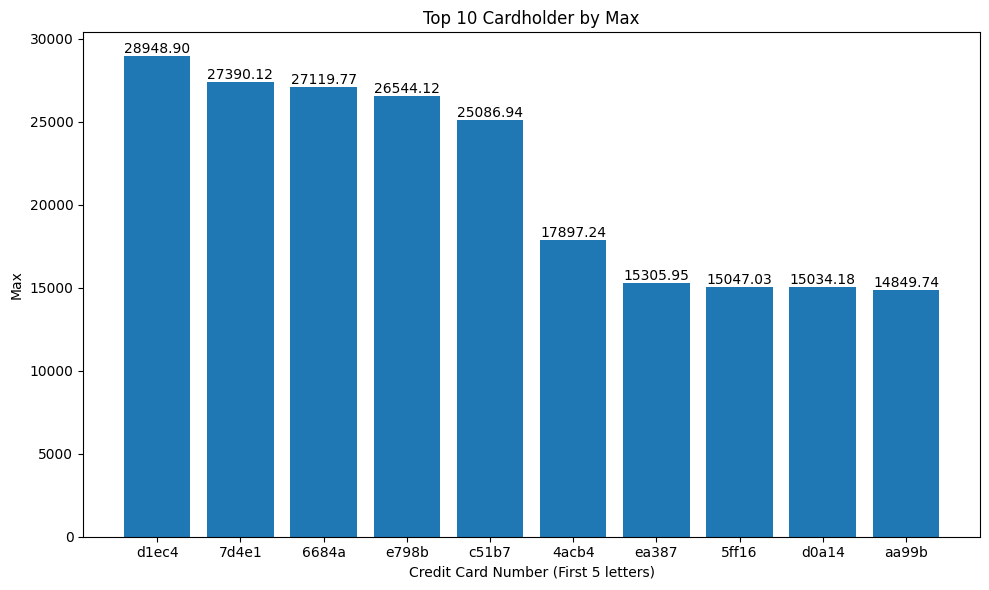

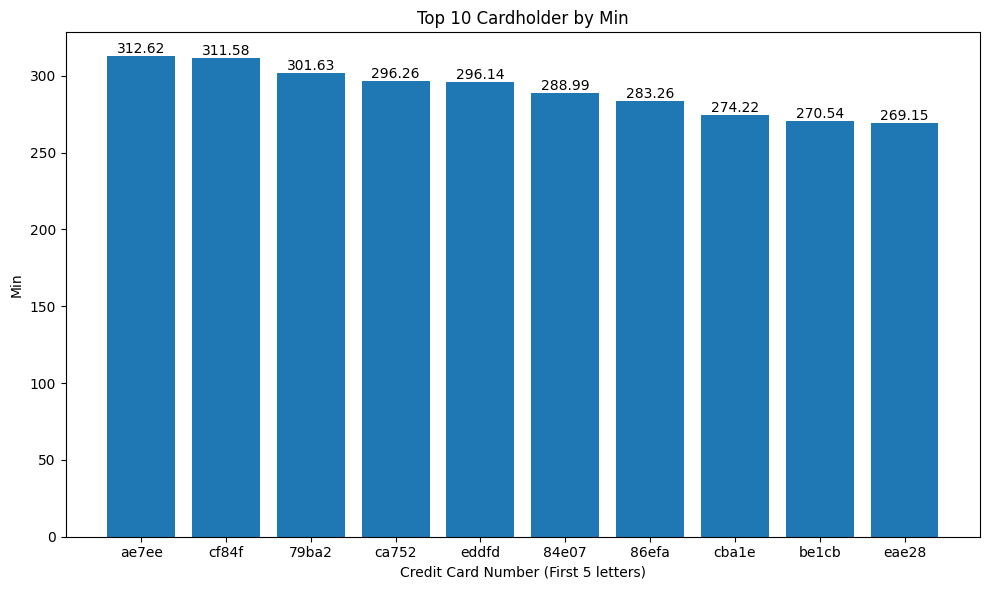

In [51]:
grouped_cc_num_df = grouped_cc_num.toPandas()

order_by = ["count", "mean", "max", "min"]

for variable in order_by:
    sorted_df = grouped_cc_num_df.sort_values(by=variable, ascending=False)

    cc_num = sorted_df["cc_num"].astype(str).str[:5][:10]
    variable_numbers = sorted_df[variable][:10]

    if variable == "count":
        count_cc = cc_num.tolist()
    elif variable == "mean":
        mean_cc = cc_num.tolist()
    elif variable == "max":
        max_cc = cc_num.tolist()

    plot_bar_chart(
        cc_num,
        variable_numbers,
        f"Top 10 Cardholder by {variable.capitalize()}",
        "Credit Card Number (First 5 letters)",
        variable.capitalize(),
    )

Identify if there's any overlap between most transaction, most highest average and maximum transaction amount 

In [52]:
print(count_cc)
print(mean_cc)
print(max_cc)

['27762', '1d23a', 'e2097', 'adcf6', 'd593f', '84cab', '3f128', '0d5e6', 'fa469', 'a3a62']
['cf84f', 'f59a1', 'ae7ee', 'eae28', 'eddfd', '1974e', '84e07', '86efa', '793ae', '96a13']
['d1ec4', '7d4e1', '6684a', 'e798b', 'c51b7', '4acb4', 'ea387', '5ff16', 'd0a14', 'aa99b']


In [53]:
count_cc_set = set(count_cc)
mean_cc_set = set(mean_cc)
max_cc_set = set(max_cc)

overlap_count_mean = count_cc_set & mean_cc_set
overlap_count_max = count_cc_set & max_cc_set
overlap_mean_max = mean_cc_set & max_cc_set

overlap_all = count_cc_set & mean_cc_set & max_cc_set

print("Overlap between count_cc and mean_cc:", overlap_count_mean)
print("Overlap between count_cc and max_cc:", overlap_count_max)
print("Overlap between mean_cc and max_cc:", overlap_mean_max)
print("Overlap across all three:", overlap_all)

Overlap between count_cc and mean_cc: set()
Overlap between count_cc and max_cc: set()
Overlap between mean_cc and max_cc: set()
Overlap across all three: set()


The statistics for the number of transaction, the maximum and minimum amount spent, as well as the average amount spent from all the transactions gives us an insight into the customer spending behavior or variations between customers spending habits. 

From the number of transactions by cardholder, the customers that are making the most transactions are around 3k transactions, with little difference among the top 10. However, making the most transactions does not necessarily mean that they spend the most money as can be seen, there are no overlaps between those that has the highest number of transaction with those with high average transaction amount and those that spend the highest on 1 transaction.

There is a significant difference between cardholders with the highest average transaction amounts and those with the highest maximum transaction amounts which means that customer distribution may vary across different income demographics.

### Customer Demographics

In [54]:
customer_demographics = ["gender", "job", "state", "city"]

In [55]:
customer_df = transaction_data.df.select(
    "cc_num", "dob", "gender", "state", "city", "street", "zip", "lat", "long", "job"
).dropDuplicates(["cc_num"])

In [56]:
customer_data = Dataset(customer_df)

In [57]:
plot_columns = [
    {"column": "gender", "plot": "pie"},
    {"column": "job", "plot": "bar"},
    {"column": "state", "plot": "bar"},
    {"column": "city", "plot": "bar"},
]

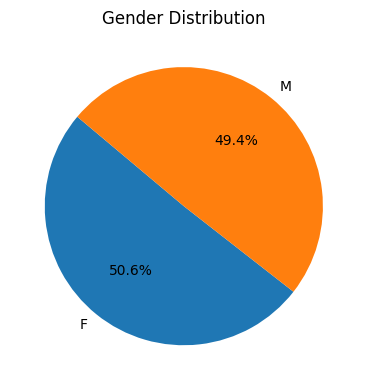

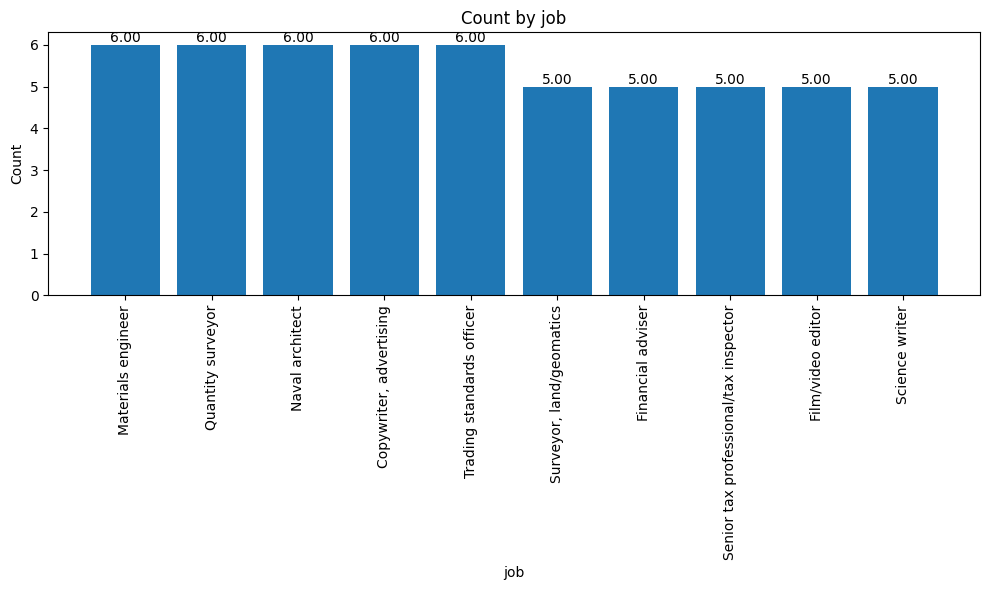

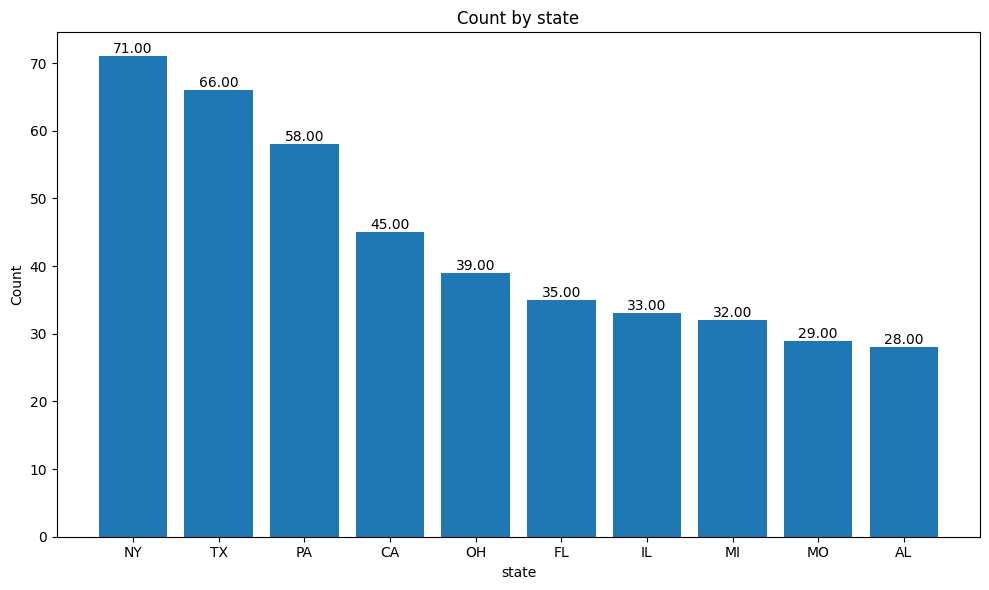

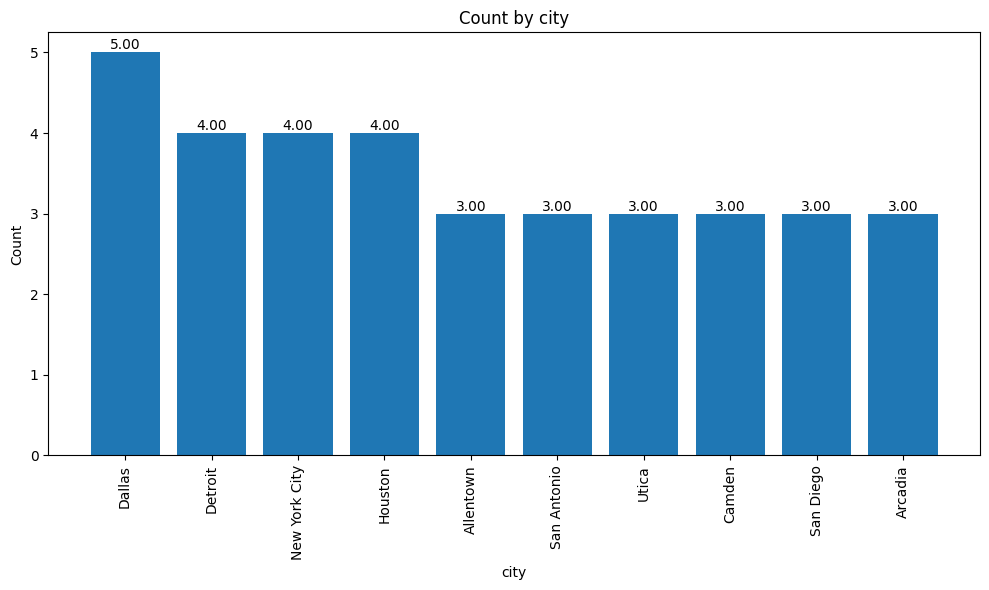

In [58]:
for i in plot_columns:
    column = i["column"]
    plot = i["plot"]
    rotate = None
    if plot == "pie":
        df_count = customer_data.get_column_values_count(
            column, show_all=True
        ).toPandas()
        plot_pie_chart(df_count["count"], df_count[column], "Gender Distribution")
    elif plot == "bar":
        df_count = customer_data.get_column_values_count(
            column, num_show=10
        ).toPandas()[:10]
        if column in ["job", "city"]:
            rotate = 90
        plot_bar_chart(
            df_count[column],
            df_count["count"],
            f"Count by {column}",
            column,
            "Count",
            rotate=rotate,
        )

Create new column age by  calculating the difference from today's date to their dob

In [59]:
customer_data.df = customer_data.df.withColumn(
    "age", (datediff(current_date(), col("dob")) / 365.25).cast(IntegerType())
)

In [60]:
customer_data.describe_column(["age"])

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|               983|
|   mean|  53.9206510681587|
| stddev|18.458789096020386|
|    min|                19|
|    max|               100|
+-------+------------------+



Apply binning to categorize customer into age groups

In [61]:
customer_data.df = customer_data.df.withColumn(
    "age_group",
    when((col("age") >= 18) & (col("age") < 30), "18-29")
    .when((col("age") >= 30) & (col("age") < 40), "30-39")
    .when((col("age") >= 40) & (col("age") < 50), "40-49")
    .when((col("age") >= 50) & (col("age") < 60), "50-59")
    .when(col("age") >= 60, "60+")
    .otherwise("Unknown"),
)

In [62]:
grouped_age_group = customer_data.df.groupBy("age_group").agg(
    count("age_group").alias("count")
)

In [63]:
grouped_age_group.show()

+---------+-----+
|age_group|count|
+---------+-----+
|    30-39|  183|
|      60+|  366|
|    40-49|  163|
|    18-29|   82|
|    50-59|  189|
+---------+-----+



In [64]:
grouped_age_group_df = grouped_age_group.toPandas()

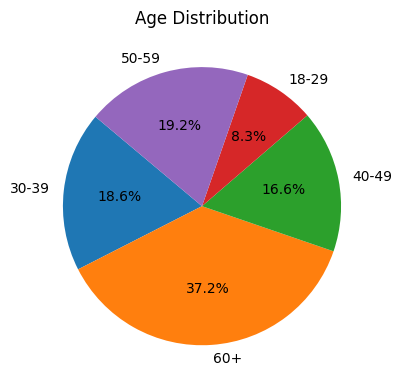

In [65]:
plot_pie_chart(
    grouped_age_group_df["count"], grouped_age_group_df["age_group"], "Age Distribution"
)

## Merchant Analysis

In [66]:
merchant_column = ["category", "cc_bic", "merchant"]

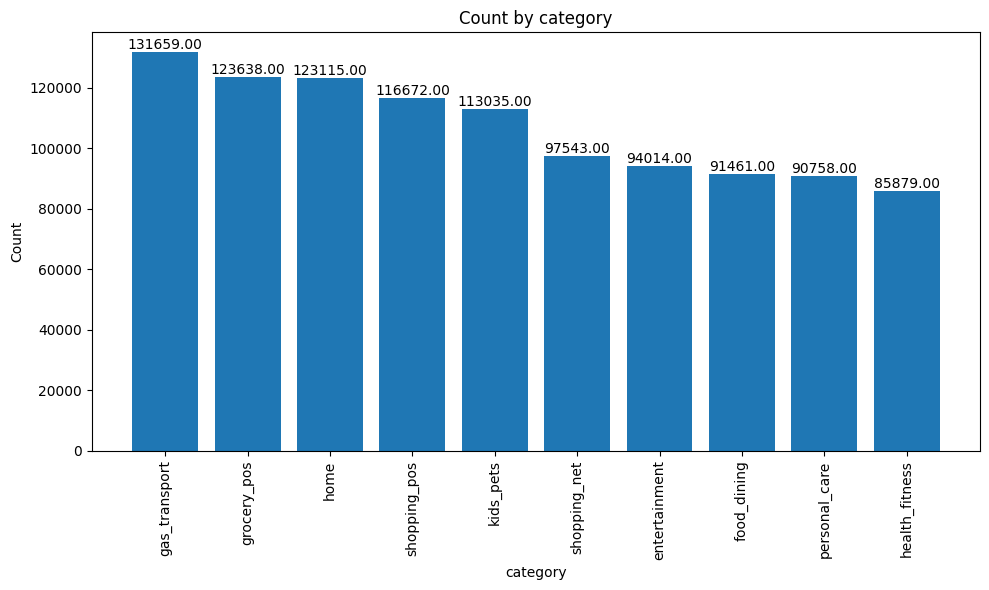

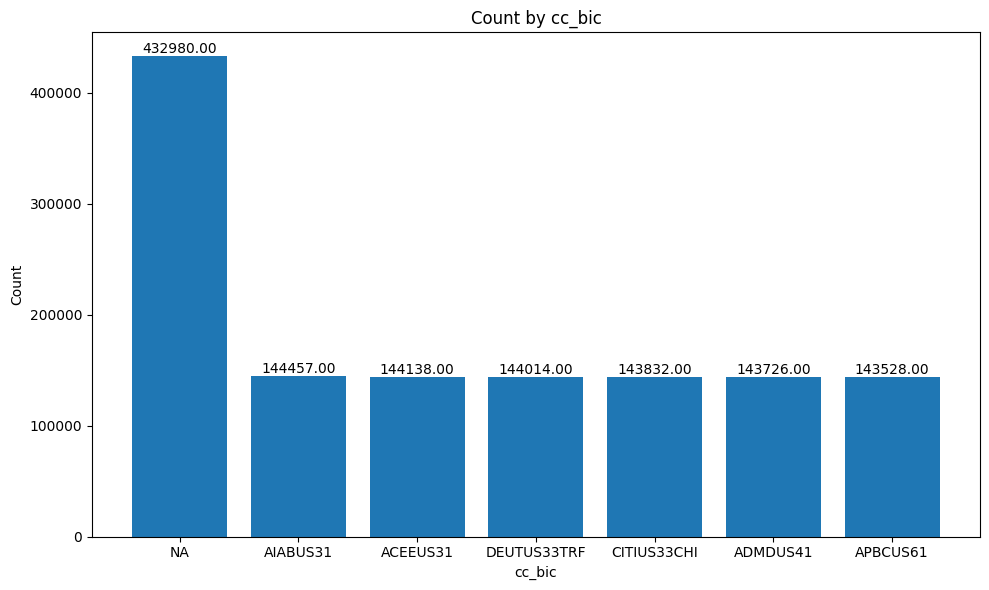

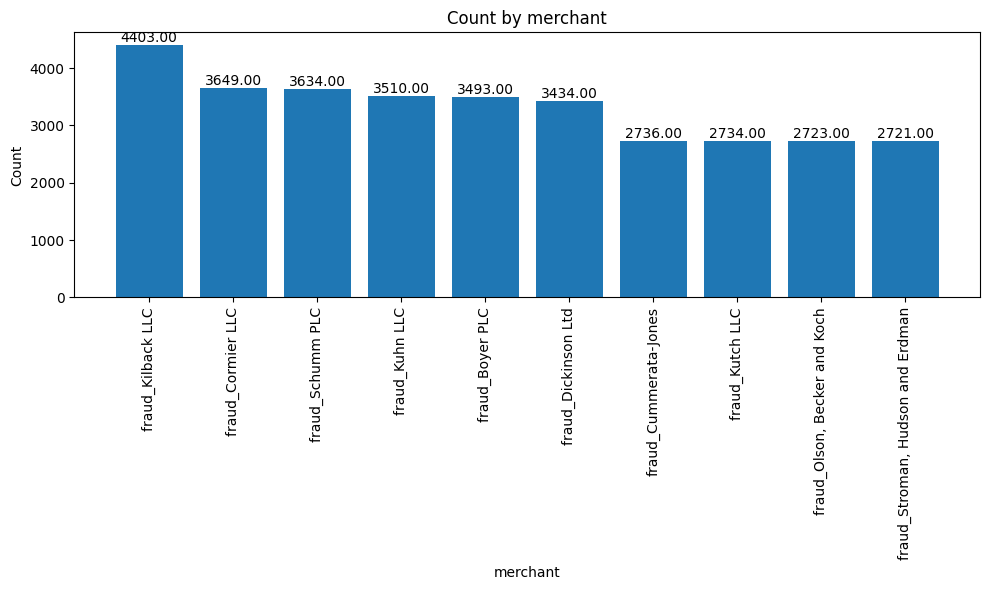

In [67]:
for column in merchant_column:
    rotate = None
    df_count = transaction_data.get_column_values_count(column, num_show=10).toPandas()[
        :10
    ]
    if column in ["merchant", "category"]:
        rotate = 90
    plot_bar_chart(
        df_count[column],
        df_count["count"],
        f"Count by {column}",
        column,
        "Count",
        rotate=rotate,
    )

## Fraud Analysis

Percentage of fraud across all transactions

In [68]:
fraud_percentage = transaction_data.get_column_values_count("is_fraud").toPandas()

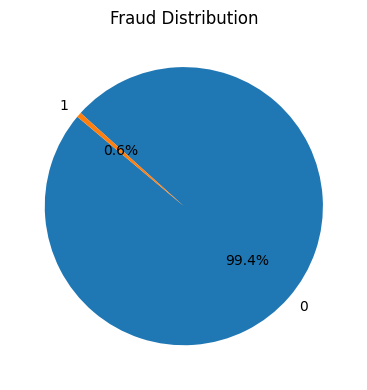

In [69]:
plot_pie_chart(
    fraud_percentage["count"], fraud_percentage["is_fraud"], "Fraud Distribution"
)

Calculate number of fraud transaction for each cardholder

In [71]:
transaction_data.select_columns(["is_fraud"])

+--------+
|is_fraud|
+--------+
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
|0       |
+--------+
only showing top 20 rows



In [76]:
grouped_cc_num_fraud = (
    transaction_data.df.groupBy("cc_num")
    .agg(sum(col("is_fraud")).alias("fraud_transaction_count"))
    .toPandas()
)

In [77]:
grouped_cc_num_fraud.describe()

,fraud_transaction_count
count,983.000000
mean,7.635809
std,4.870588
min,0.000000
25%,4.000000
50%,9.000000
75%,11.000000
max,19.000000


In [80]:
num_fraud = len(
    grouped_cc_num_fraud[grouped_cc_num_fraud["fraud_transaction_count"] > 0]
)
num_no_fraud = len(
    grouped_cc_num_fraud[grouped_cc_num_fraud["fraud_transaction_count"] == 0]
)

print(f"Number of cardholders with fraud transactions: {num_fraud}")
print(f"Number of cardholders without fraud transactions: {num_no_fraud}")

Number of cardholders with fraud transactions: 762
Number of cardholders without fraud transactions: 221


From the statistics above, although the percentage of fraud transaction is only 0.6% out of all transaction, but more cardholders have fraud transactions rather than not as we can see only 221 cardholders has never had a fraudulent transaction.

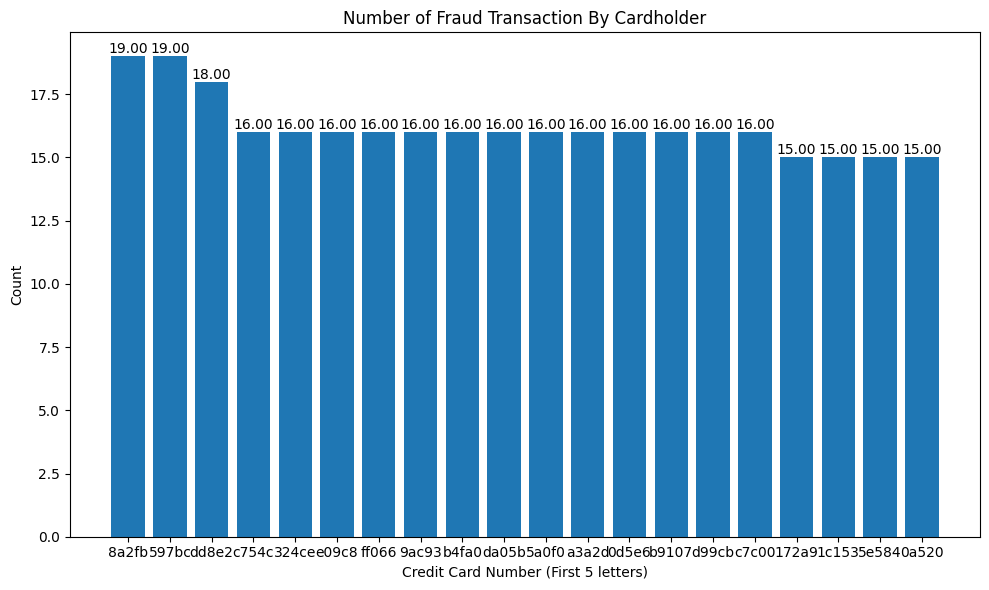

In [81]:
sorted_df = grouped_cc_num_fraud.sort_values(
    by="fraud_transaction_count", ascending=False
)

cc_num = sorted_df["cc_num"].astype(str).str[:5][:20]
variable_numbers = sorted_df["fraud_transaction_count"][:20]

plot_bar_chart(
    cc_num,
    variable_numbers,
    f"Number of Fraud Transaction By Cardholder",
    "Credit Card Number (First 5 letters)",
    "Count",
)

For the cardholders that have the most fraud transactions, the top 20 ranges around 19-15 fraud transactions